<a href="https://colab.research.google.com/github/KarinAmir/Smile-analysis_model/blob/main/biometrics_task_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.7042531080005574
GPU (s):
0.04709531600019545
GPU speedup over CPU: 78x


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/moheb432/principles-of-smile.git cloned-repo
%cd cloned-repo
!ls

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/content/cloned-repo
'biometrics_dataset - Sheet1.csv'  'teeth_not cropped'
 cloned-repo			    test.csv
 cropped_teeth			    train.csv
 dataset.csv			    Untitled.ipynb
 dataset_split.ipynb		    valid.csv
 mobile-net.ipynb		    vgg.ipynb
 model.h5			    weight_converting.ipynb
 my_h5_model.h5			    weights.hkl
 README.md


In [4]:
from tensorflow import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from time import time
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [5]:
def append_ext(fn):
    return fn+".jpg"
df = pd.read_csv("dataset.csv")
df["img"] = df["img"].apply(append_ext)
df = df.replace(np.nan, 0)

columns = ['gummy', 'golden_proportion ', 'gap', 'crowding',
       'incisal embrassure ', 'color', 'Central line', 'gum tissue health',
       'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect']
df=df.sample(frac=1).reset_index(drop=True)
df.columns

Index(['img', 'gummy', 'golden_proportion ', 'gap', 'crowding',
       'incisal embrassure ', 'color', 'Central line', 'gum tissue health',
       'Crooked', 'Central Incisor W/H Ratio', 'Black triangle', 'perfect',
       'labels'],
      dtype='object')

In [6]:

train_data_generation = ImageDataGenerator(rescale=1./255)

training_set = train_data_generation.flow_from_dataframe(dataframe=df[:155],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=columns,
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode="raw",seed=3)
# preprocessing the testing set
valid_data_generation = ImageDataGenerator(rescale=1./255)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[155:175],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=columns,
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode="raw",seed=3)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[175:],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=None,
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode=None,seed=0)



Found 155 validated image filenames.
Found 20 validated image filenames.
Found 19 validated image filenames.


# **VGG16:**
![Build Status](https://images4.arabicprogrammer.com/948/02/02b6266c608492d1007bbb560e762ab4.png)

In [7]:

def vgg():
  
  input = Input([224,224,3])
  
  x = Conv2D(64,3, activation='relu')(input)
  x = Conv2D(64, 64, activation='relu')(x)
 
  x = MaxPool2D(2, strides=2)(x)
  
  x = Conv2D(64, 3, padding='same', activation='relu')(x)
  x = Conv2D(128,3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)
  
  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = Conv2D(256, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)
  
  x = Conv2D(256,3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)
  
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = Conv2D(512, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(2, strides=2, padding='same')(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='relu')(x)
  x = Dense(4096, activation='relu')(x)
  
  output = Dense(12, activation='softmax')(x)
  model = Model(input, output)
  
  return model

model=vgg()
model.summary()
E_S= EarlyStopping(monitor='val_binary_accuracy',
                   patience=6
                   ,mode='max'
                   , restore_best_weights=True
                   )


model.compile(optimizer='adam',
              loss = 'BinaryCrossentropy',
              metrics = ['BinaryAccuracy'])
history=model.fit(x=training_set, 
                  validation_data=valid_set, 
                  epochs=50,
                  callbacks=[E_S])

model.save("model.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_23 (Conv2D)          (None, 159, 159, 64)      16777280  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 64)       0         
 )                                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 79, 79, 64)        36928     
                                                                 
 conv2d_25 (Conv2D)          (None, 79, 79, 128)       73856     
                                                             

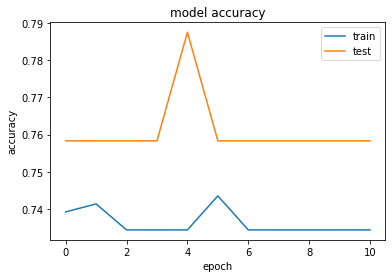

In [8]:

model.save("my_h5_model.h5")

history.history
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [9]:
# model.load_model("model.h5")
predictions= model.predict(test_set)
y=[]
print("10 Sample predictions:")
for pred in predictions:

  pred[pred>0.6]=1
  pred[pred<=0.6]=0
pd.DataFrame(predictions)

10 Sample predictions:


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
